In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
sns.set()

import os
print(os.listdir("../input"))

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

train = pd.read_csv('../input/train.csv', index_col='id')
test = pd.read_csv('../input/test.csv', index_col='id')

structures = pd.read_csv('../input/structures.csv')

def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

['potential_energy.csv', 'mulliken_charges.csv', 'train.csv', 'scalar_coupling_contributions.csv', 'sample_submission.csv', 'structures', 'test.csv', 'magnetic_shielding_tensors.csv', 'dipole_moments.csv', 'structures.csv']


/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [27]:
%%time
# This block is SPPED UP

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist_speedup'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist_speedup'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

CPU times: user 352 ms, sys: 140 ms, total: 492 ms
Wall time: 486 ms


In [28]:
train.head(5)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist_speedup
0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157
4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952


In [29]:
train['same_atom'] = (train['atom_0'] == train['atom_1']).astype('int')

In [34]:
train_part = train.loc[:10000]

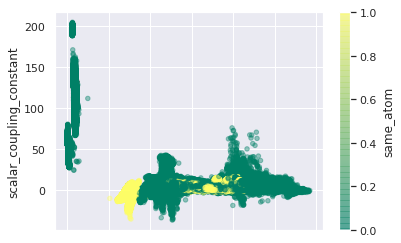

In [40]:
train.plot.scatter(x = 'dist_speedup', y = 'scalar_coupling_constant', c = 'same_atom',
                       cmap = 'summer', alpha = 0.4)
plt.show()

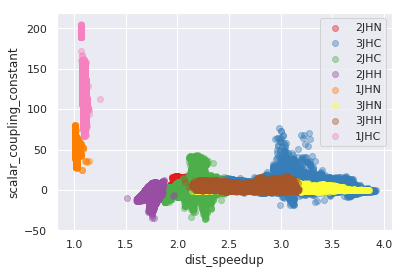

In [41]:
list_type = list(set(train['type']))
cNorm  = colors.Normalize(vmin=0, vmax=len(list_type))
cmap_plot = plt.get_cmap('Set1')
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap_plot)

for i in range(len(list_type)):
    indx = train['type'] == list_type[i]
    plt.scatter(x = train.loc[indx, 'dist_speedup'], y = train.loc[indx, 'scalar_coupling_constant'],
               color = scalarMap.to_rgba(i), label = list_type[i], alpha = 0.4)
    
plt.xlabel('dist_speedup')
plt.ylabel('scalar_coupling_constant')
plt.legend(loc='upper right')
plt.show()

## It turns out very segmented pattern!
## Hope its helps